Simulating differential pointing
====

This notebook treats about the simulation of differential pointing between same pair detectors.

In [5]:
## Import basic modules and routines
from __future__ import division, absolute_import, print_function

## In case you did not install properly the library 
## or didn't update your bashrc. (Do it later!)
import os
path_to_s4cmb = '../../s4cmb'
os.sys.path.insert(0, os.path.realpath(path_to_s4cmb))

import healpy as hp
import pylab as pl
import numpy as np
from copy import deepcopy

## Import modules and routines from s4cmb
from s4cmb.input_sky import HealpixFitsMap

from s4cmb.instrument import Hardware
from s4cmb.instrument import construct_beammap

from s4cmb.scanning_strategy import ScanningStrategy

from s4cmb.tod import TimeOrderedDataPairDiff
from s4cmb.tod import OutputSkyMap
from s4cmb.tod import partial2full

from s4cmb.systematics import modify_beam_offsets

try:
    from tqdm import *
except ImportError:
    tqdm = lambda x: x

Flow is the following: sky + instrument + scanning strategy --> map2tod --> perturb beam centroids --> tod2map.

Initialise our instrument, scanning strategy and input maps as seen in the Part 1 lectures. 

In [15]:
## Instrument
inst = Hardware(ncrate=4, ndfmux_per_crate=1,
                nsquid_per_mux=1, npair_per_squid=16,
                fp_size=60., fwhm=1.0, 
                beam_seed=58347, projected_fp_size=3., pm_name='5params',
                type_hwp='CRHWP', freq_hwp=2., angle_hwp=0., verbose=False)

## Input maps
nside = 2048
path_to_cls = '../../s4cmb/s4cmb/data/test_data_set_lensedCls.dat'
sky_in = HealpixFitsMap(path_to_cls, do_pol=True, 
                        fwhm_in=inst.beam_model.fwhm, nside_in=nside, 
                        map_seed=5843787, verbose=False, 
                        no_ileak=False, no_quleak=False)

## Scanning strategy
scan = ScanningStrategy(nces=12, start_date='2013/1/1 00:00:00',
                        telescope_longitude='-67:46.816',
                        telescope_latitude='-22:56.396', telescope_elevation=5200.,
                        name_strategy='deep_patch', sampling_freq=8., sky_speed=0.4,
                        ut1utc_fn='../../s4cmb/s4cmb/data/ut1utc.ephem', 
                        language='fortran')
scan.run()

Let's inject differential pointing between 
two pixel-pair bolometers in our data!
The model is the following:
* Draw from a normal distribution G(mu, sigma) the magnitudes of the differential pointing rho.
* Draw from a uniform distribution U(0, 2pi) the directions of the differential pointing theta.
* Move the position of bottom bolometers as
     - x_top/bottom = \pm rho / 2 * cos(theta)
     - y_top/bottom = \pm rho / 2 * sin(theta)
     
et voilà!

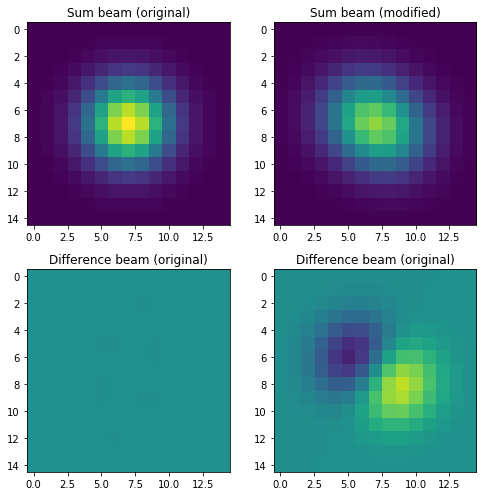

In [23]:
## For visualisation purposes only we keep a copy
## of the initial position
inst_mod = deepcopy(inst)

## Inject quarter-beam differential pointing (exaggerated!)
inst_mod.beam_model.xpos, inst_mod.beam_model.ypos = \
    modify_beam_offsets(inst_mod.beam_model.xpos, 
                        inst_mod.beam_model.ypos,
                        mu_diffpointing=30., 
                        sigma_diffpointing=15., 
                        seed=5847)

## Let's have a look at our beam parameters now
## Let's plot the resulting beam map for a pixel in the focal plane
summap_original, diffmap_original = construct_beammap(
    inst.beam_model, ct=0, cb=1, nx=15, 
    pix_size=0.2 / 180. * np.pi / 60.)
summap_modified, diffmap_modified = construct_beammap(
    inst_mod.beam_model, ct=0, cb=1, nx=15, 
    pix_size=0.2 / 180. * np.pi / 60.)

fig, ax = pl.subplots(2,2, figsize=(7, 7))

ax[0, 0].imshow(summap_original, vmin=0, vmax=1)
ax[0, 0].set_title('Sum beam (original)')
ax[0, 1].imshow(summap_modified, vmin=0, vmax=1)
ax[0, 1].set_title('Sum beam (modified)')

ax[1, 0].imshow(diffmap_original, vmin=-0.4, vmax=0.4)
ax[1, 0].set_title('Difference beam (original)')
ax[1, 1].imshow(diffmap_modified, vmin=-0.4, vmax=0.4)
ax[1, 1].set_title('Difference beam (original)')
pl.tight_layout()
pl.show()

Let's now generate our TOD from our input sky, instrument, and scanning strategy We will use the difference of pairs of detectors to reconstruct the polarisation (no demodulation). We will also inject instrument noise in time-domain.
Once we will have the timestreams, we will reconstruct our maps on a sky patch of width 20 deg at a resolution nside = 2048. We also show the residual map at each step alongside with the hit count map.

100%|██████████| 128/128 [00:11<00:00, 11.49it/s]


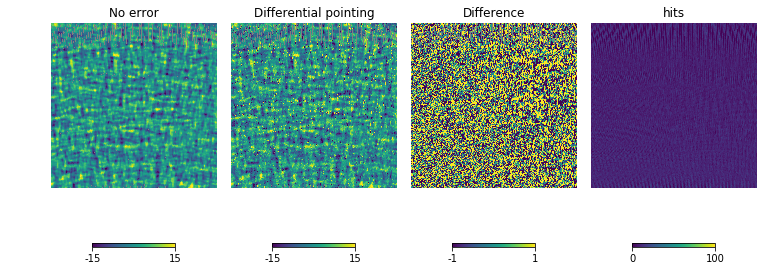

100%|██████████| 128/128 [00:06<00:00, 20.61it/s]


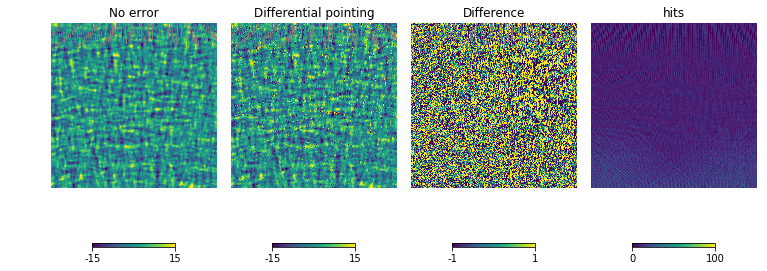

100%|██████████| 128/128 [00:07<00:00, 18.44it/s]


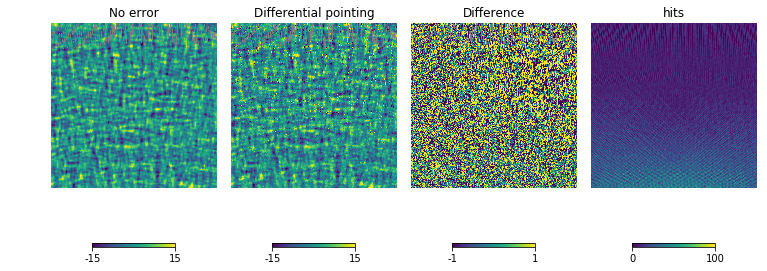

100%|██████████| 128/128 [00:07<00:00, 16.68it/s]


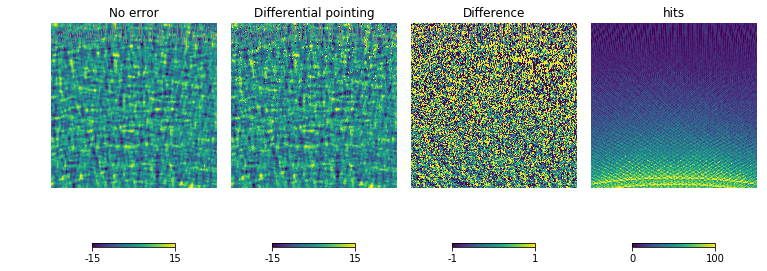

100%|██████████| 128/128 [00:07<00:00, 17.95it/s]


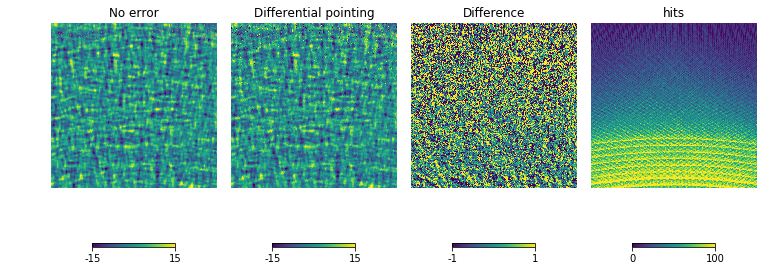

100%|██████████| 128/128 [00:07<00:00, 17.26it/s]


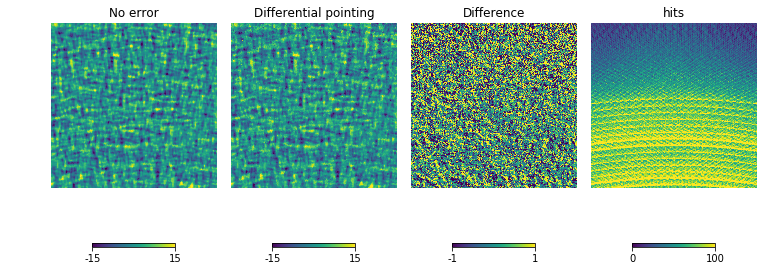

100%|██████████| 128/128 [00:07<00:00, 18.06it/s]


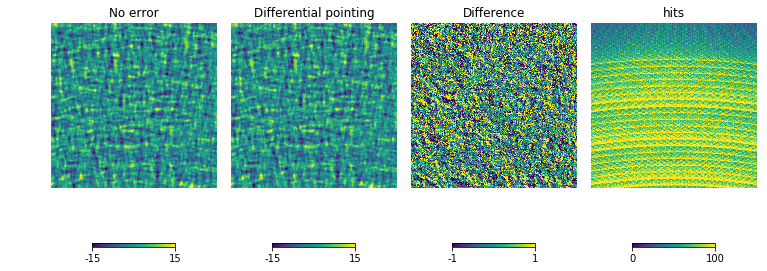

100%|██████████| 128/128 [00:07<00:00, 18.08it/s]


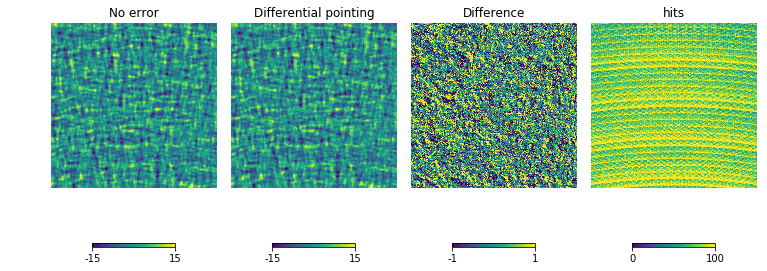

100%|██████████| 128/128 [00:06<00:00, 18.00it/s]


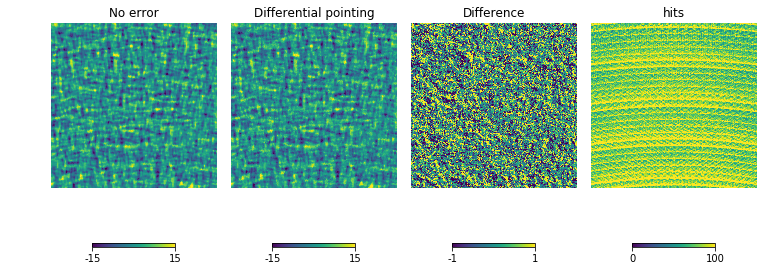

100%|██████████| 128/128 [00:05<00:00, 22.05it/s]


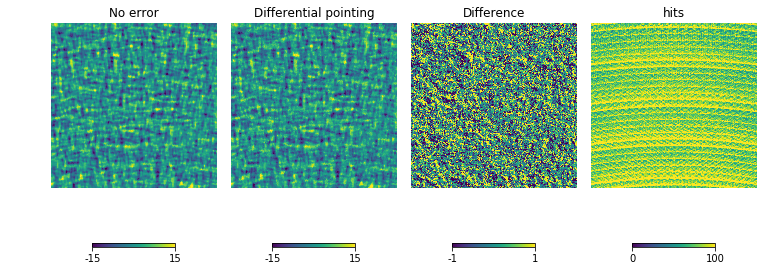

100%|██████████| 128/128 [00:05<00:00, 24.83it/s]


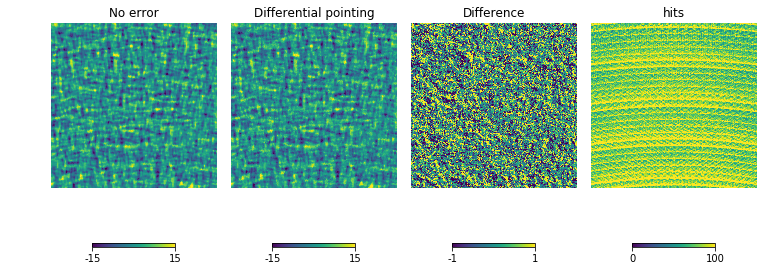

100%|██████████| 128/128 [00:10<00:00, 13.62it/s]


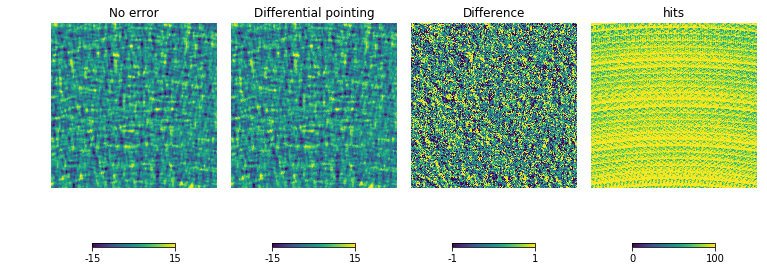

In [26]:
## Loop over CESs: noiseless simulations
## For visualisation purposes, we reconstruct both with and without systematics
histograms = []
xsize = 330
reso = 1.7
    
for CESnumber in range(scan.nces):
    tod_mod = TimeOrderedDataPairDiff(
        inst_mod, scan, sky_in, 
        CESnumber=CESnumber, 
        projection='healpix', 
        nside_out=nside, 
        width=20.,
        array_noise_level=None,
        array_noise_seed=None,
        mapping_perpair=False)
    
    ## Initialise map containers
    if CESnumber == 0:
        sky_out_tot_mod = OutputSkyMap(
            projection=tod_mod.projection, 
            nside=tod_mod.nside_out, 
            obspix=tod_mod.obspix)
        
    ## Scan input map to get TODs
    d_mod = np.array(
        [tod_mod.map2tod(det) for det in tqdm(
                range(inst_mod.focal_plane.nbolometer))])
    
    ## Project TOD to maps
    tod_mod.tod2map(d_mod, sky_out_tot_mod)
    
    ## Plot Stokes Q maps at each step
    nhit = partial2full(
        sky_out_tot_mod.nhit, 
        sky_out_tot_mod.obspix, 
        sky_out_tot_mod.nside, 
        fill_with=0.0)
    
    sky_out = sky_in.Q + 0.0
    
    sky_out_mod = partial2full(
        sky_out_tot_mod.get_QU()[0], 
        sky_out_tot_mod.obspix, 
        sky_out_tot_mod.nside, 
        fill_with=0.0)
    
    mask = nhit < 3
    sky_out[mask] = np.nan
    sky_out_mod[mask] = np.nan
    
    fig = pl.figure(figsize=(10, 10))
    
    hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=reso, sub=141, 
                title='No error', notext=True, min=-15, max=15)
    hp.gnomview(sky_out_mod, rot=[0, -57.5], xsize=xsize, reso=reso, sub=142, 
                title='Differential pointing', notext=True, min=-15, max=15)
    hp.gnomview(sky_out_mod - sky_out, rot=[0, -57.5], 
                xsize=xsize, reso=reso, sub=143, 
                title='Difference', notext=True, min=-1, max=1)
    hp.gnomview(nhit, rot=[0, -57.5], xsize=xsize, reso=reso, sub=144, 
                title='hits', notext=True, min=0, max=100)
    pl.show()
    
    h, b, _ = pl.hist(
        (sky_out_mod[~mask] - sky_out[~mask])/np.sqrt(nhit[~mask]), 
        bins=50, histtype='step', 
        lw=2, range=[-5, 5])
    
    histograms.append(h)
    pl.clf()

Let's have a look at the pre-whitened residual in intensity, that is dI/sqrt(nhit).
The residual decreases as we add more scans, i.e. the effect averages down:

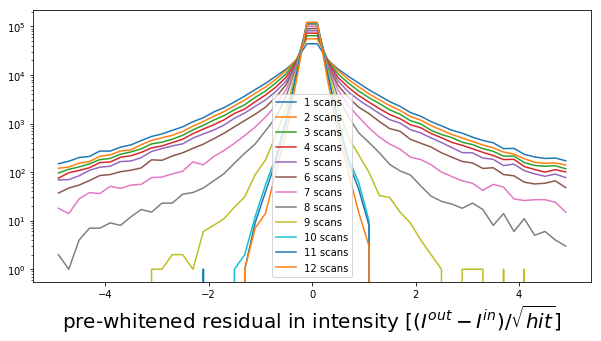

In [27]:
fig = pl.figure(figsize=(10, 5))

for pos, h in enumerate(histograms):
    pl.plot(b[:-1] + np.diff(b)/2, h, label='{} scans'.format(pos + 1))
pl.legend()
pl.xlabel('pre-whitened residual in intensity [($I^{out} - I^{in} $)/$\sqrt{hit}$]', fontsize=20)
pl.yscale('log')
pl.show()

Zoom on 4 pairs of bolometers in the focal plane:

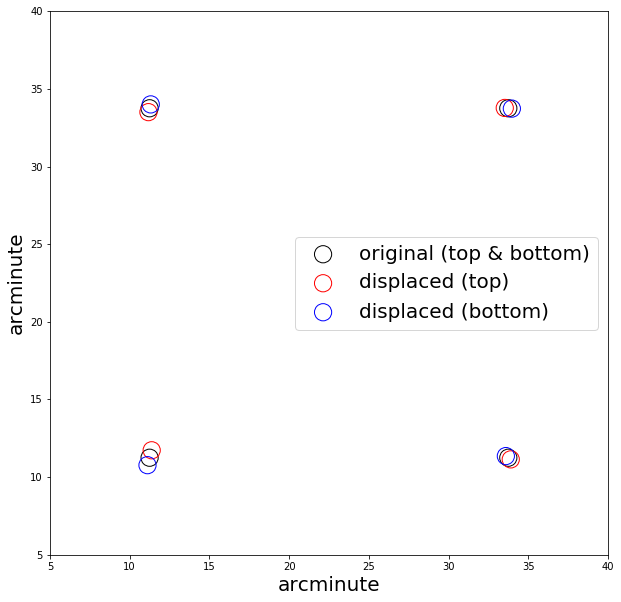

In [28]:
fig = pl.figure(figsize=(10, 10))

liminf = 5
limsup = 40
point2am = (np.max(inst.beam_model.xpos) - np.min(inst.beam_model.xpos))/(10. * fig.dpi)*180./np.pi*60
scale = (np.max(inst.beam_model.xpos) - np.min(inst.beam_model.xpos))*180./np.pi*60 / (limsup - liminf)

pl.scatter(inst.beam_model.xpos[::2]*180./np.pi*60,inst.beam_model.ypos[::2]*180./np.pi*60,
           c='None',alpha=1,s=np.pi*(inst.beam_model.fwhm/point2am)**2*scale,marker='o',
           label='original (top & bottom)', edgecolors='black')
pl.scatter(inst_mod.beam_model.xpos[::2]*180./np.pi*60,inst_mod.beam_model.ypos[::2]*180./np.pi*60,
           c='None',alpha=1,s=np.pi*(inst.beam_model.fwhm/point2am)**2*scale,marker='o', 
           label='displaced (top)', edgecolors='red')
pl.scatter(inst_mod.beam_model.xpos[1::2]*180./np.pi*60,inst_mod.beam_model.ypos[1::2]*180./np.pi*60,
           c='None',alpha=1,s=np.pi*(inst.beam_model.fwhm/point2am)**2*scale,marker='o', 
           label='displaced (bottom)', edgecolors='blue')
pl.xlim(liminf, limsup)
pl.ylim(liminf, limsup)
pl.xlabel('arcminute', fontsize=20)
pl.ylabel('arcminute', fontsize=20)
pl.legend(fontsize=20)
pl.show()

Note that this example is not so realistic as one would need
an input map with higher resolution and smaller deviations (keep in mind we want to displace
things by few arcseconds!). But the code would stay exactly the same in other circumstances!

Note also that you can easily scan an input map at a resolution nside_in, but reconstruct the output map at resolution nside_out != nside_in. For example in Polarbear, to study small pointing effects (differential pointing mismatches are at the arcsecond level), we used to scan an input map with nside_in = 65,536 and reconstruct at nside_out = 2048. 